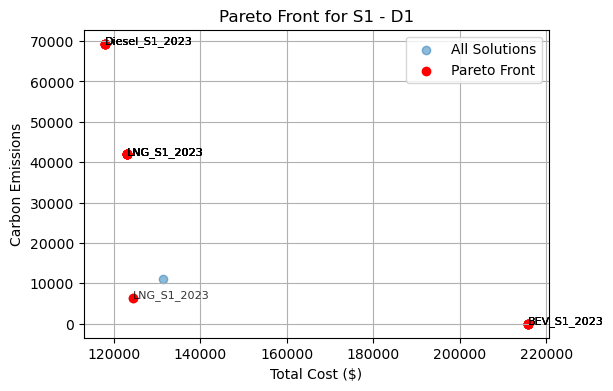

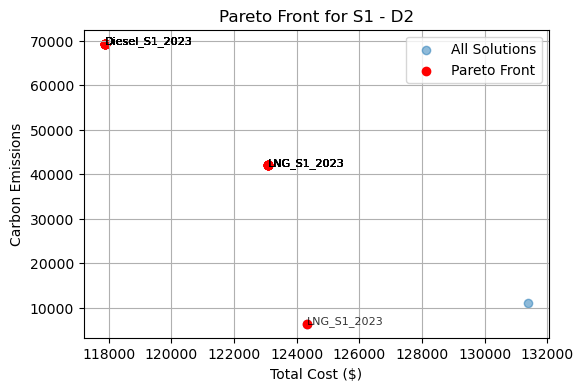

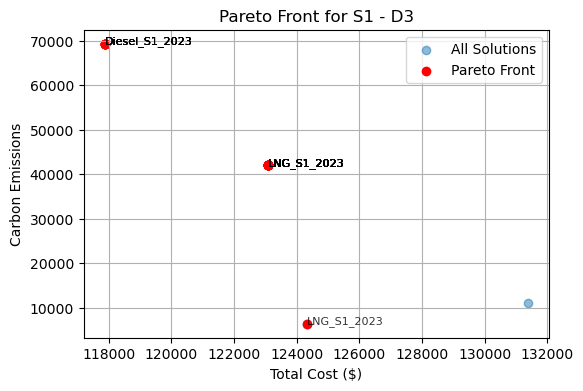

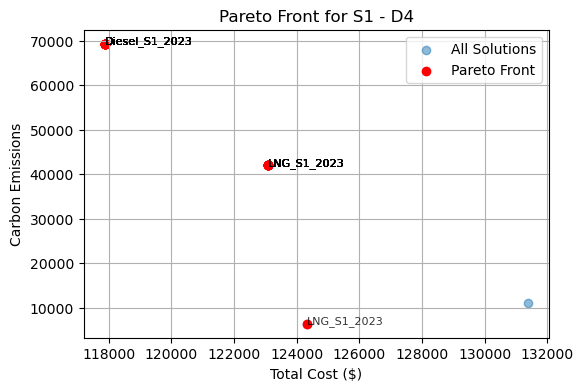

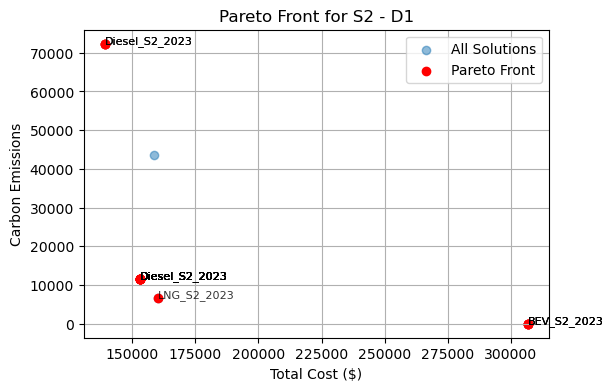

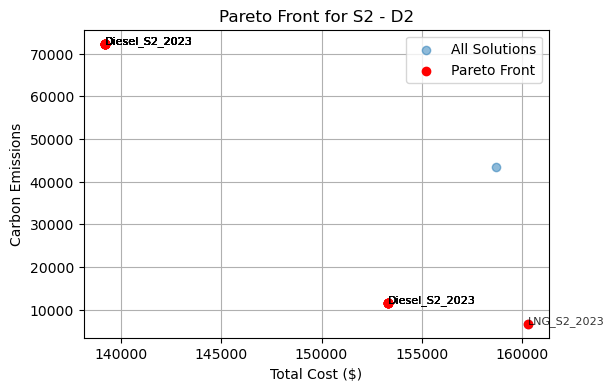

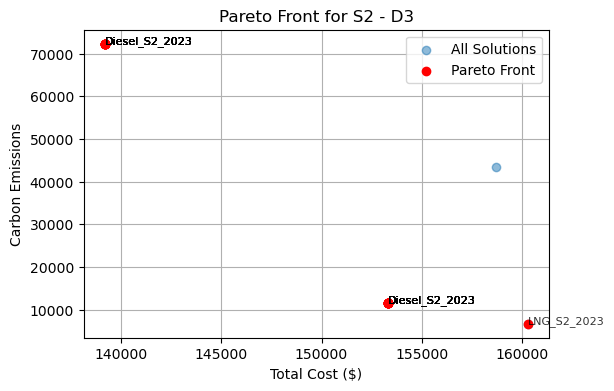

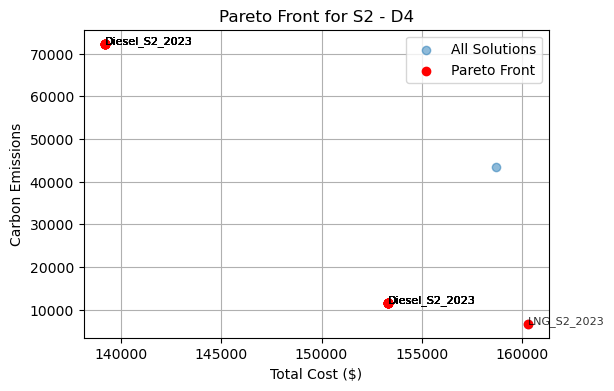

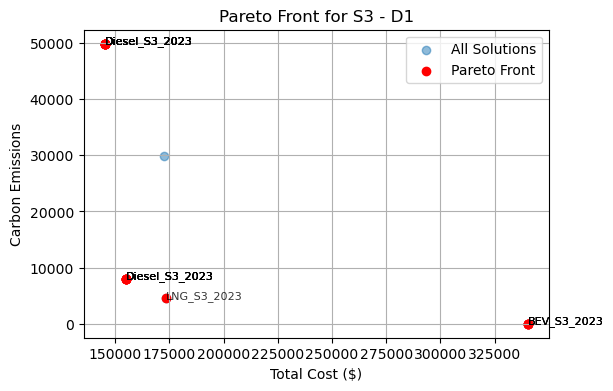

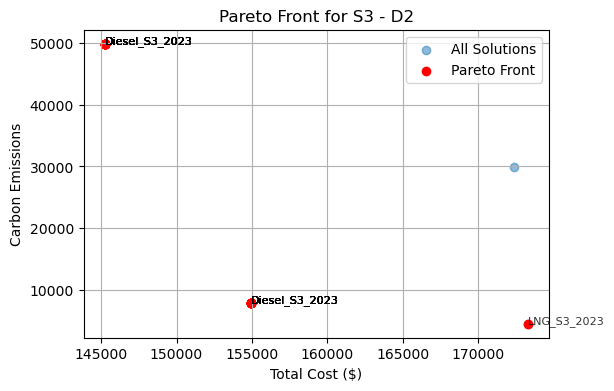

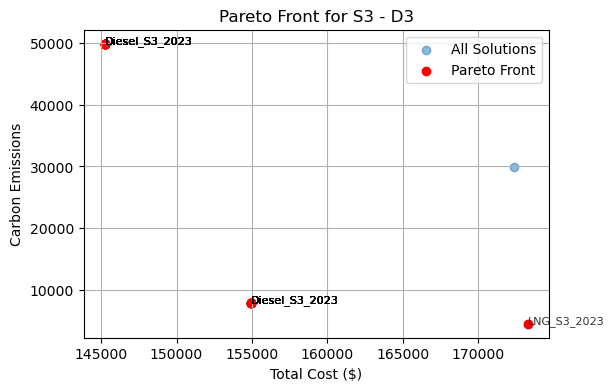

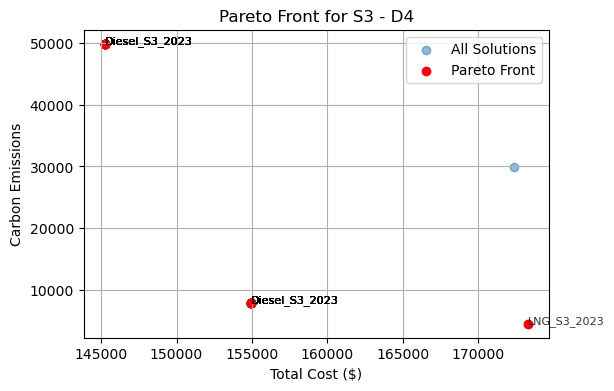

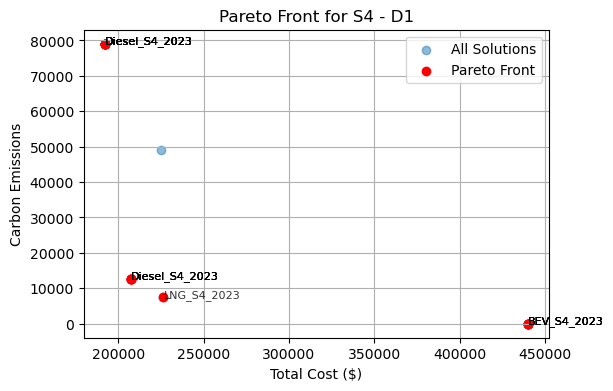

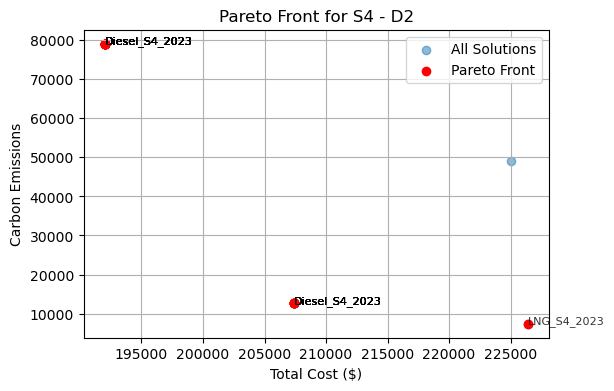

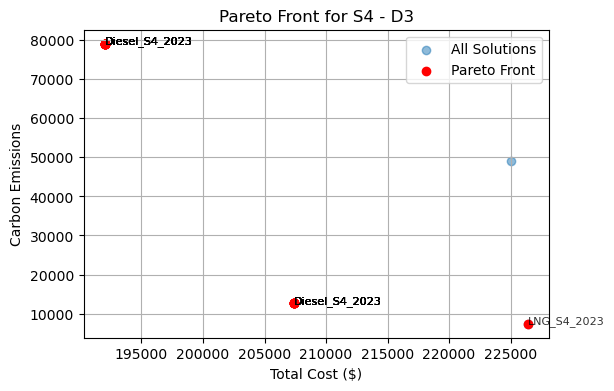

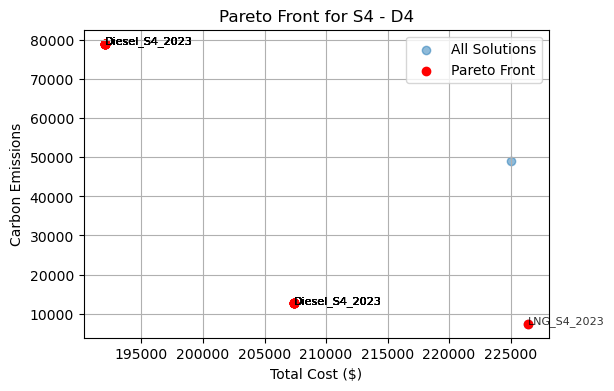

    Size Distance_x      Allocation     Total Cost  Carbon Emissions  \
0     S1         D1     BEV_S1_2023  215690.316221          0.000000   
1     S1         D1     BEV_S1_2023  215690.316221          0.000000   
2     S1         D1  Diesel_S1_2023  117871.219051      69347.975963   
3     S1         D1  Diesel_S1_2023  117871.219051      69347.975963   
4     S1         D1     LNG_S1_2023  124325.652865       6375.265894   
..   ...        ...             ...            ...               ...   
315   S4         D4  Diesel_S4_2023  207410.770276      12648.764684   
316   S4         D4  Diesel_S4_2023  192016.404172      79078.903088   
317   S4         D4  Diesel_S4_2023  192016.404172      79078.903088   
318   S4         D4  Diesel_S4_2023  207410.770276      12648.764684   
319   S4         D4  Diesel_S4_2023  192016.404172      79078.903088   

            Fuel  
0    Electricity  
1    Electricity  
2            B20  
3            B20  
4         BioLNG  
..           ...  
31

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
# from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM


# Load the dataset
file_path = "filtered_file.csv"  # Update with the correct path if needed
df = pd.read_csv(file_path)

# Ensure numerical columns are correctly formatted
df["Total Cost"] = df["insurance_cost"] + df["maintenance_cost"] + df["fuel_costs"] + df["Cost"]

# Define the optimization problem
class VehicleOptimizationProblem(ElementwiseProblem):
    def __init__(self, subset):
        super().__init__(n_var=1, n_obj=2, n_constr=0, xl=0, xu=len(subset)-1)
        self.subset = subset.reset_index(drop=True)

    def _evaluate(self, x, out, *args, **kwargs):
        x = int(x[0])  # Convert to index
        out["F"] = [self.subset.loc[x, "Total Cost"], self.subset.loc[x, "carbon_emissions"]]

# Store Pareto optimal solutions
pareto_solutions = []

# Unique (Size, Distance_x) combinations
combinations = df.groupby(["Size", "Distance_x"])

# Process each group separately
for (size, distance_x), group in combinations:
    group = group.copy().reset_index(drop=True)

    # Define problem instance
    problem = VehicleOptimizationProblem(group)

    algorithm = NSGA2(pop_size=20,
                  sampling=IntegerRandomSampling(),
                  crossover=SBX(prob=0.9, eta=15),
                  mutation=PM(eta=20),
                  eliminate_duplicates=True)


    # # NSGA-II algorithm
    # algorithm = NSGA2(pop_size=20,
    #                   sampling=get_sampling("int_random"),
    #                   crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    #                   mutation=get_mutation("real_pm", eta=20),
    #                   eliminate_duplicates=True)

    # Solve the problem
    res = minimize(problem, algorithm, termination=('n_gen', 50), verbose=False)

    # Extract Pareto front
    pareto_front = res.F
    pareto_allocations = [group.iloc[int(ind[0])]["Allocation"] for ind in res.X]

    # Store results
    # for alloc, cost, carbon in zip(pareto_allocations, pareto_front[:, 0], pareto_front[:, 1]):
        # pareto_solutions.append((size, distance_x, alloc, cost, carbon)) 
        # Store only the last generation's Pareto optimal solutions
    if res.X is not None and len(res.X) > 0:
        last_gen_pareto_front = res.F  # Last generation's Pareto front
        last_gen_allocations = [group.iloc[int(ind[0])]["Allocation"] for ind in res.X]

        for alloc, cost, carbon in zip(last_gen_allocations, last_gen_pareto_front[:, 0], last_gen_pareto_front[:, 1]):
            fuel_type = group[group["carbon_emissions"] == carbon]["Fuel"].values[0]
            pareto_solutions.append((size, distance_x, alloc, cost, carbon,fuel_type))
   

    # Plot Pareto front with allocation labels
    plt.figure(figsize=(6, 4))
    plt.scatter(group["Total Cost"], group["carbon_emissions"], label="All Solutions", alpha=0.5)
    plt.scatter(pareto_front[:, 0], pareto_front[:, 1], color="red", label="Pareto Front")

    # Add labels for each point
    for i, alloc in enumerate(pareto_allocations):
        plt.annotate(alloc, (pareto_front[i, 0], pareto_front[i, 1]), fontsize=8, alpha=0.8)

    plt.xlabel("Total Cost ($)")
    plt.ylabel("Carbon Emissions")
    plt.title(f"Pareto Front for {size} - {distance_x}")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Pareto front
    # plt.figure(figsize=(6, 4))
    # plt.scatter(group["Total Cost"], group["carbon_emissions"], label="All Solutions", alpha=0.5)
    # plt.scatter(pareto_front[:, 0], pareto_front[:, 1], color="red", label="Pareto Front")
    # plt.xlabel("Total Cost ($)")
    # plt.ylabel("Carbon Emissions")
    # plt.title(f"Pareto Front for {size} - {distance_x}")
    # plt.legend()
    # plt.grid()
    # plt.show()

# Convert results to a DataFrame
pareto_df = pd.DataFrame(pareto_solutions, columns=["Size", "Distance_x", "Allocation", "Total Cost", "Carbon Emissions","Fuel"])

# Save and print Pareto optimal solutions
# pareto_df.to_csv("pareto_optimal_solutions.csv", index=False)
print(pareto_df)


In [18]:
# Convert to DataFrame
pareto_df = pd.DataFrame(pareto_solutions, columns=["Size", "Distance_x", "Allocation", "Total Cost", "Carbon Emissions","Fuel"])

# Compute the number of vehicles required
pareto_df["Num Vehicles"] = pareto_df.apply(
    lambda row: df[(df["Size"] == row["Size"]) & (df["Distance_x"] == row["Distance_x"])].iloc[0]["Demand (km)"] / 
                df[(df["Size"] == row["Size"]) & (df["Distance_x"] == row["Distance_x"])].iloc[0]["Yearly range (km)"], 
    axis=1
)

# Save only final selections to CSV
# pareto_df.to_csv("pareto_optimal_solutions_final.csv", index=False)

# Print final selections
pareto_df


,Size,Distance_x,Allocation,Total Cost,Carbon Emissions,Fuel,Num Vehicles
0,S1,D1,BEV_S1_2023,215690.316221,0.000000,Electricity,8.521382
1,S1,D1,BEV_S1_2023,215690.316221,0.000000,Electricity,8.521382
2,S1,D1,Diesel_S1_2023,117871.219051,69347.975963,B20,8.521382
3,S1,D1,Diesel_S1_2023,117871.219051,69347.975963,B20,8.521382
4,S1,D1,LNG_S1_2023,124325.652865,6375.265894,BioLNG,8.521382
...,...,...,...,...,...,...,...
315,S4,D4,Diesel_S4_2023,207410.770276,12648.764684,HVO,0.015331
316,S4,D4,Diesel_S4_2023,192016.404172,79078.903088,B20,0.015331
317,S4,D4,Diesel_S4_2023,192016.404172,79078.903088,B20,0.015331
318,S4,D4,Diesel_S4_2023,207410.770276,12648.764684,HVO,0.015331


In [20]:
pareto_df = pareto_df.drop_duplicates()

# Save and print Pareto optimal solutions
pareto_df.to_csv("pareto_optimal_solutions_final.csv", index=False)
print(pareto_df)

    Size Distance_x      Allocation     Total Cost  Carbon Emissions  \
0     S1         D1     BEV_S1_2023  215690.316221          0.000000   
2     S1         D1  Diesel_S1_2023  117871.219051      69347.975963   
4     S1         D1     LNG_S1_2023  124325.652865       6375.265894   
5     S1         D1     LNG_S1_2023  123077.879517      41971.148530   
20    S1         D2     LNG_S1_2023  124325.652865       6375.265894   
21    S1         D2  Diesel_S1_2023  117871.219051      69347.975963   
23    S1         D2     LNG_S1_2023  123077.879517      41971.148530   
40    S1         D3  Diesel_S1_2023  117871.219051      69347.975963   
41    S1         D3     LNG_S1_2023  124325.652865       6375.265894   
43    S1         D3     LNG_S1_2023  123077.879517      41971.148530   
60    S1         D4  Diesel_S1_2023  117871.219051      69347.975963   
62    S1         D4     LNG_S1_2023  124325.652865       6375.265894   
63    S1         D4     LNG_S1_2023  123077.879517      41971.14

In [ ]:
pareto_df = 

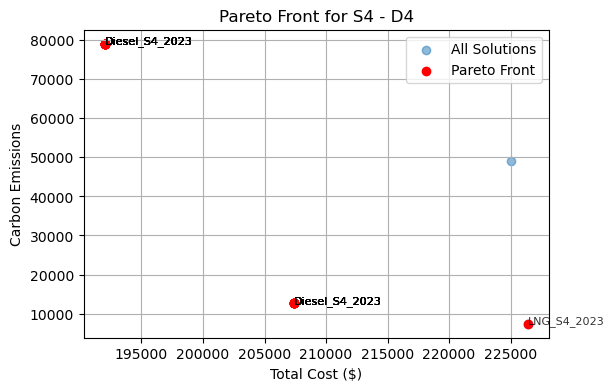

In [5]:
# Plot Pareto front with allocation labels
plt.figure(figsize=(6, 4))
plt.scatter(group["Total Cost"], group["carbon_emissions"], label="All Solutions", alpha=0.5)
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], color="red", label="Pareto Front")

# Add labels for each point
for i, alloc in enumerate(pareto_allocations):
    plt.annotate(alloc, (pareto_front[i, 0], pareto_front[i, 1]), fontsize=8, alpha=0.8)

plt.xlabel("Total Cost ($)")
plt.ylabel("Carbon Emissions")
plt.title(f"Pareto Front for {size} - {distance_x}")
plt.legend()
plt.grid()
plt.show()


In [2]:
pip install numpy pandas matplotlib pymoo


Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --upgrade pymoo


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Compute the number of vehicles required
pareto_df["Num Vehicles"] = pareto_df.apply(
    lambda row: df[(df["Size"] == row["Size"]) & (df["Distance_x"] == row["Distance_x"])].iloc[0]["Demand"] / 
                df[(df["Size"] == row["Size"]) & (df["Distance_x"] == row["Distance_x"])].iloc[0]["Yearly ran"], 
    axis=1
)

# Save and print updated Pareto optimal solutions
pareto_df.to_csv("pareto_optimal_solutions_with_vehicles.csv", index=False)
print(pareto_df)


KeyError: 'Demand'

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       34 |     10 |             - |             -
     2 |       84 |     27 |  0.000000E+00 |             f
     3 |      134 |     50 |  0.000000E+00 |             f
     4 |      184 |     50 |  0.000000E+00 |             f
     5 |      234 |     50 |  0.000000E+00 |             f
     6 |      284 |     50 |  0.000000E+00 |             f
     7 |      334 |     50 |  0.000000E+00 |             f
     8 |      384 |     50 |  0.000000E+00 |             f
     9 |      434 |     50 |  0.000000E+00 |             f
    10 |      484 |     50 |  0.000000E+00 |             f
    11 |      534 |     50 |  0.000000E+00 |             f
    12 |      584 |     50 |  0.000000E+00 |             f
    13 |      634 |     50 |  0.000000E+00 |             f
    14 |      684 |     50 |  0.000000E+00 |             f
    15 |      734 |     50 |  0.000000E+00 |             f
    16 |      784 |     50 |  0.000000E+00 |            

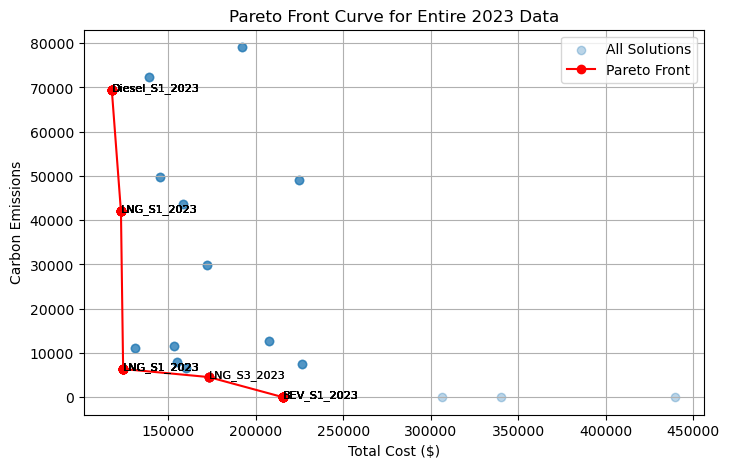

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

# Load the dataset
file_path = "filtered_file.csv"  # Update with the correct path if needed
df = pd.read_csv(file_path)

# Ensure numerical columns are correctly formatted
df["Total Cost"] = df["insurance_cost"] + df["maintenance_cost"] + df["fuel_costs"] + df["Cost"]

# Define the optimization problem for the entire dataset
class VehicleOptimizationProblem(ElementwiseProblem):
    def __init__(self, dataset):
        super().__init__(n_var=1, n_obj=2, n_constr=0, xl=0, xu=len(dataset)-1)
        self.dataset = dataset.reset_index(drop=True)

    def _evaluate(self, x, out, *args, **kwargs):
        x = int(x[0])  # Convert to index
        out["F"] = [self.dataset.loc[x, "Total Cost"], self.dataset.loc[x, "carbon_emissions"]]

# Define problem instance for the entire dataset
problem = VehicleOptimizationProblem(df)

algorithm = NSGA2(
    pop_size=50,  # Increased population size for better Pareto front
    sampling=IntegerRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# Solve the problem
res = minimize(problem, algorithm, termination=('n_gen', 100), verbose=True)

# Extract Pareto front and vehicle details
pareto_solutions = []
if res.X is not None and len(res.X) > 0:
    pareto_front = res.F  # Pareto front points
    selected_indices = [int(ind[0]) for ind in res.X]

    for idx, cost, carbon in zip(selected_indices, pareto_front[:, 0], pareto_front[:, 1]):
        vehicle_info = df.iloc[idx]  # Get full vehicle details
        pareto_solutions.append({
            "Allocation": vehicle_info["Allocation"],
            "Total Cost": cost,
            "Carbon Emissions": carbon,
            "Fuel Type": vehicle_info["Fuel"]
        })

# Convert results to a DataFrame
pareto_df = pd.DataFrame(pareto_solutions)

# Save and print Pareto optimal solutions with vehicle details
pareto_df.to_csv("pareto_vehicle_details.csv", index=False)
print(pareto_df)

# Sort Pareto front points for a smooth curve
pareto_df = pareto_df.sort_values(by="Total Cost")

# Plot Pareto front curve
plt.figure(figsize=(8, 5))
plt.scatter(df["Total Cost"], df["carbon_emissions"], label="All Solutions", alpha=0.3)
plt.plot(pareto_df["Total Cost"], pareto_df["Carbon Emissions"], color="red", marker="o", linestyle="-", label="Pareto Front")

# Add labels for each point
for i, alloc in enumerate(pareto_df["Allocation"]):
    plt.annotate(alloc, (pareto_df["Total Cost"].iloc[i], pareto_df["Carbon Emissions"].iloc[i]), fontsize=8, alpha=0.8)

plt.xlabel("Total Cost ($)")
plt.ylabel("Carbon Emissions")
plt.title("Pareto Front Curve for Entire 2023 Data")
plt.legend()
plt.grid()
plt.show()


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       35 |     10 |             - |             -
     2 |       85 |     30 |  0.9288727079 |         nadir
     3 |      135 |     50 |  0.000000E+00 |             f
     4 |      185 |     50 |  0.000000E+00 |             f
     5 |      235 |     50 |  0.000000E+00 |             f
     6 |      285 |     50 |  0.000000E+00 |             f
     7 |      335 |     50 |  0.000000E+00 |             f
     8 |      385 |     50 |  0.000000E+00 |             f
     9 |      435 |     50 |  0.000000E+00 |             f
    10 |      485 |     50 |  0.000000E+00 |             f
    11 |      535 |     50 |  0.000000E+00 |             f
    12 |      585 |     50 |  0.000000E+00 |             f
    13 |      635 |     50 |  0.000000E+00 |             f
    14 |      685 |     50 |  0.000000E+00 |             f
    15 |      735 |     50 |  0.000000E+00 |             f
    16 |      785 |     50 |  0.000000E+00 |            

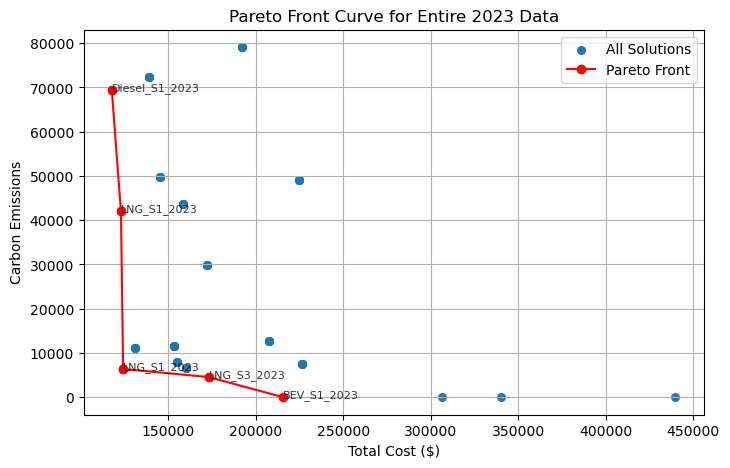

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

# Load the dataset
file_path = "filtered_file.csv"  # Update with the correct path if needed
df = pd.read_csv(file_path)

# Ensure numerical columns are correctly formatted
df["Total Cost"] = df["insurance_cost"] + df["maintenance_cost"] + df["fuel_costs"] + df["Cost"]

# Define the optimization problem for the entire dataset
class VehicleOptimizationProblem(ElementwiseProblem):
    def __init__(self, dataset):
        super().__init__(n_var=1, n_obj=2, n_constr=0, xl=0, xu=len(dataset)-1)
        self.dataset = dataset.reset_index(drop=True)

    def _evaluate(self, x, out, *args, **kwargs):
        x = int(x[0])  # Convert to index
        out["F"] = [self.dataset.loc[x, "Total Cost"], self.dataset.loc[x, "carbon_emissions"]]

# Define problem instance for the entire dataset
problem = VehicleOptimizationProblem(df)

algorithm = NSGA2(
    pop_size=50,  # Increased population size for better Pareto front
    sampling=IntegerRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# Solve the problem
res = minimize(problem, algorithm, termination=('n_gen', 100), verbose=True)

# Extract Pareto front and vehicle details
pareto_solutions = []
if res.X is not None and len(res.X) > 0:
    pareto_front = res.F  # Pareto front points
    selected_indices = [int(ind[0]) for ind in res.X]

    # Extract unique non-dominated solutions
    pareto_set = set()
    for idx, cost, carbon in zip(selected_indices, pareto_front[:, 0], pareto_front[:, 1]):
        if (cost, carbon) not in pareto_set:  # Avoid duplicates
            vehicle_info = df.iloc[idx]
            pareto_solutions.append({
                "Allocation": vehicle_info["Allocation"],
                "Total Cost": cost,
                "Carbon Emissions": carbon,
                "Fuel Type": vehicle_info["Fuel"],
            })
            pareto_set.add((cost, carbon))

# Convert results to a DataFrame
pareto_df = pd.DataFrame(pareto_solutions)

# Sort Pareto front for smooth visualization
pareto_df = pareto_df.sort_values(by="Total Cost")

# Save only the final non-dominated solutions to CSV
pareto_df.to_csv("pareto_vehicle_details.csv", index=False)
print("Saved final Pareto front vehicle details to 'pareto_vehicle_details.csv'")
print(pareto_df)

# Plot Pareto front curve (only non-dominated solutions)
plt.figure(figsize=(8, 5))
plt.scatter(df["Total Cost"], df["carbon_emissions"], label="All Solutions", alpha=1.0,s=30)
plt.plot(pareto_df["Total Cost"], pareto_df["Carbon Emissions"], color="red", marker="o", linestyle="-", label="Pareto Front")

# Add labels for each point (Only non-dominated ones)
for i, alloc in enumerate(pareto_df["Allocation"]):
    plt.annotate(alloc, (pareto_df["Total Cost"].iloc[i], pareto_df["Carbon Emissions"].iloc[i]), fontsize=8, alpha=0.8)

plt.xlabel("Total Cost ($)")
plt.ylabel("Carbon Emissions")
plt.title("Pareto Front Curve for Entire 2023 Data")
plt.legend()
plt.grid()
plt.show()


In [34]:
import numpy as np
import pandas as pd

def calculate_crowding_distance(pareto_df):
    """
    Compute crowding distance for Pareto front solutions.
    
    Args:
    pareto_df (DataFrame): Contains Pareto solutions with "Total Cost" and "Carbon Emissions".
    
    Returns:
    DataFrame: Pareto solutions with an additional "Crowding Distance" column.
    """
    num_solutions = len(pareto_df)
    if num_solutions == 0:
        return pareto_df

    # Initialize crowding distance array
    crowding_distance = np.zeros(num_solutions)

    # Convert DataFrame to NumPy array for calculations
    objectives = ["Total Cost", "Carbon Emissions"]
    values = pareto_df[objectives].values  # Extract objective values as a NumPy array

    # Compute crowding distance for each objective
    for m in range(values.shape[1]):  
        # Sort by the current objective
        sorted_indices = np.argsort(values[:, m])
        sorted_values = values[sorted_indices, m]

        # Assign infinite distance to boundary points (first and last points)
        crowding_distance[sorted_indices[0]] = np.inf
        crowding_distance[sorted_indices[-1]] = np.inf

        # Compute normalized crowding distance for inner points
        min_val, max_val = sorted_values[0], sorted_values[-1]
        if max_val - min_val == 0:  # Avoid division by zero
            continue

        for i in range(1, num_solutions - 1):
            crowding_distance[sorted_indices[i]] += (
                (sorted_values[i + 1] - sorted_values[i - 1]) / (max_val - min_val)
            )

    # Add crowding distance to the DataFrame
    pareto_df["Crowding Distance"] = crowding_distance

    return pareto_df

# Compute crowding distance for Pareto solutions
pareto_df = calculate_crowding_distance(pareto_df)

# Display results
print(pareto_df.sort_values(by="Crowding Distance", ascending=False))


       Allocation     Total Cost  Carbon Emissions    Fuel Type  \
0  Diesel_S1_2023  117871.219051      69347.975963          B20   
1     BEV_S1_2023  215690.316221          0.000000  Electricity   
2     LNG_S1_2023  124325.652865       6375.265894       BioLNG   
4     LNG_S3_2023  173281.858068       4549.567924       BioLNG   
3     LNG_S1_2023  123077.879517      41971.148530          LNG   

   Crowding Distance  
0                inf  
1                inf  
2           1.052853  
4           1.025948  
3           0.974052  
